In [97]:
from unittest.util import strclass
#import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [98]:
train_file_path = r"data\train.csv"
test_file_path = r"data\test.csv"
test_data = pd.read_csv(test_file_path)
train_data = pd.read_csv(train_file_path)

In [99]:
test_data.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [100]:
X_train = train_data.drop(columns=["SalePrice"])
X_target = train_data["SalePrice"]
X_test = test_data

In [101]:
X_train, Y_train, X_target, Y_target = train_test_split(X_train,X_target,test_size=0.2, random_state=42)
Y_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,480,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca
1361,1362,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
802,803,60,RL,63.0,8199,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2008,WD,Normal
651,652,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal


Ok, let's look now more deeply into missing data and also convert categorical data
Ok, let's look now more deeply into missing data and also convert categorical data


In [102]:
X_train.select_dtypes(include=['object', 'string']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='str')

In [103]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()

    # Encode categorical features
    for col in X.select_dtypes(include=["object", "string"]):
        X[col], _ = X[col].factorize()

    mi = mutual_info_regression(
        X,
        y,
        discrete_features="auto",
        random_state=random_state
    )

    mi_scores = pd.Series(mi, index=X.columns, name="MI Score")
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [104]:
def convert_nan_vals(X):
   num_cols = X.select_dtypes(include=["int64", "float64"]).columns
   cat_cols = X.select_dtypes(include=["object", "string"]).columns

   X[num_cols] = SimpleImputer(strategy="median").fit_transform(X[num_cols])
   X[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[cat_cols])
   return X

In [105]:
X = X_train.copy()
Y = Y_train.copy()
convert_nan_vals(X)
convert_nan_vals(Y)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,893.0,20.0,RL,70.0,8414.0,Pave,Pave,Reg,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2006.0,WD,Normal
1105,1106.0,60.0,RL,98.0,12256.0,Pave,Pave,IR1,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,4.0,2010.0,WD,Normal
413,414.0,30.0,RM,56.0,8960.0,Pave,Grvl,Reg,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,3.0,2010.0,WD,Normal
522,523.0,50.0,RM,50.0,5000.0,Pave,Pave,Reg,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,10.0,2006.0,WD,Normal
1036,1037.0,20.0,RL,89.0,12898.0,Pave,Pave,IR1,HLS,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,9.0,2009.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,480.0,30.0,RM,50.0,5925.0,Pave,Pave,Reg,Bnk,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,3.0,2007.0,WD,Alloca
1361,1362.0,20.0,RL,124.0,16158.0,Pave,Pave,IR1,Low,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,6.0,2009.0,WD,Normal
802,803.0,60.0,RL,63.0,8199.0,Pave,Pave,Reg,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,10.0,2008.0,WD,Normal
651,652.0,70.0,RL,60.0,9084.0,Pave,Pave,Reg,Lvl,AllPub,...,0.0,0.0,Gd,MnPrv,Shed,0.0,10.0,2009.0,WD,Normal


In [106]:
mi_scores = make_mi_scores(X, X_target)
print(mi_scores)

OverallQual     0.538840
GrLivArea       0.454885
Neighborhood    0.443316
GarageArea      0.365159
GarageCars      0.357560
                  ...   
3SsnPorch       0.000000
PoolArea        0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
Name: MI Score, Length: 80, dtype: float64


Finally I can drop columns where Mutual Information columns is equal to 0, because they don't have any impact on the predicting the price

In [107]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [108]:
X = drop_uninformative(X,mi_scores)
Y = drop_uninformative(Y,mi_scores)

Text(0.5, 1.0, 'Mutual Information Scores')

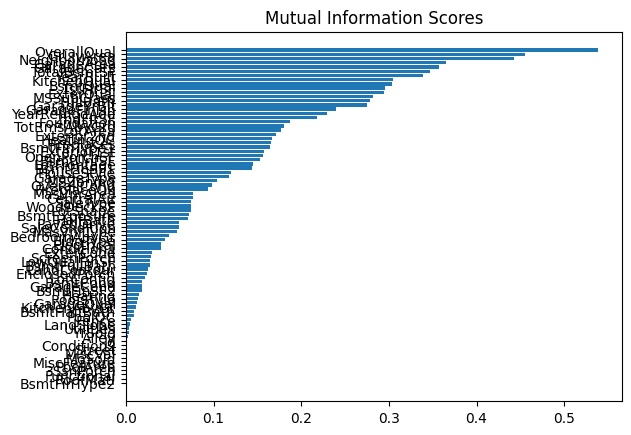

In [109]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

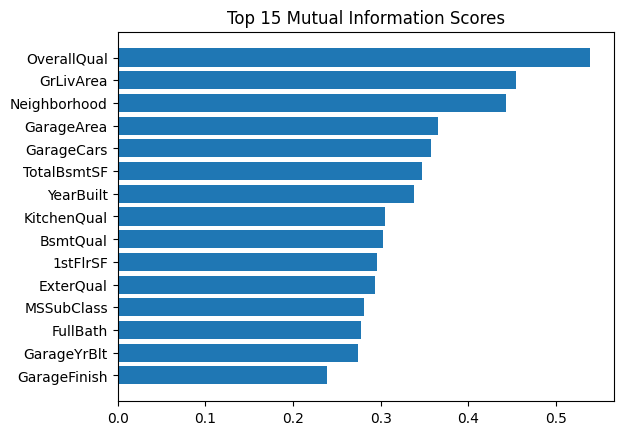

In [110]:
top_k = 15
scores = mi_scores.nlargest(top_k).sort_values()

plt.barh(scores.index, scores.values)
plt.title(f"Top {top_k} Mutual Information Scores")
plt.show()

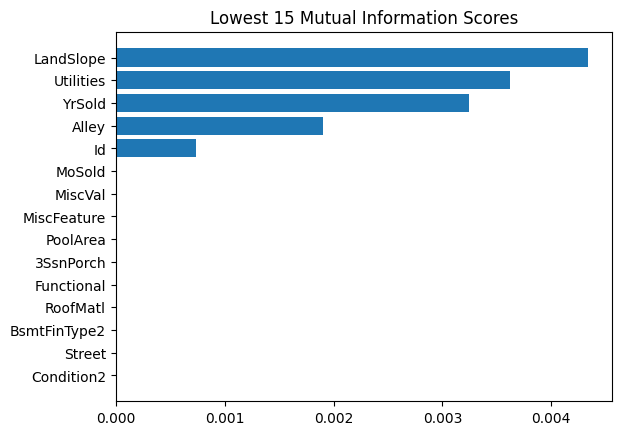

In [111]:
low_k = 15
scores = mi_scores.nsmallest(low_k)

plt.barh(scores.index, scores.values)
plt.title(f"Lowest {low_k} Mutual Information Scores")
plt.show()

In [112]:
def factorize_data(X):
    for col in X.select_dtypes(include=["object", "string"]):
        X[col], _ = X[col].factorize()
    return X

In [113]:
X = factorize_data(X)
Y = factorize_data(Y)


In [134]:
model = XGBRegressor(
    random_state=42
)
#objective="reg:squaredlogerror"

In [135]:
model.fit(X,X_target,verbose=True,eval_set = [(Y,Y_target)])

[0]	validation_0-rmse:81476.00227
[1]	validation_0-rmse:76801.91511
[2]	validation_0-rmse:72471.86326
[3]	validation_0-rmse:68346.28350
[4]	validation_0-rmse:64565.04004
[5]	validation_0-rmse:61767.24080
[6]	validation_0-rmse:59073.82882
[7]	validation_0-rmse:56059.73921
[8]	validation_0-rmse:53905.89235
[9]	validation_0-rmse:51505.65840
[10]	validation_0-rmse:49079.87999
[11]	validation_0-rmse:47377.52216
[12]	validation_0-rmse:45428.79629
[13]	validation_0-rmse:44048.45895
[14]	validation_0-rmse:42657.93248
[15]	validation_0-rmse:41402.90561
[16]	validation_0-rmse:40182.47553
[17]	validation_0-rmse:39094.58571
[18]	validation_0-rmse:38041.30884
[19]	validation_0-rmse:37068.32692
[20]	validation_0-rmse:36153.04439
[21]	validation_0-rmse:35309.31115
[22]	validation_0-rmse:34512.06124
[23]	validation_0-rmse:33950.06993
[24]	validation_0-rmse:33618.62914
[25]	validation_0-rmse:33387.41280
[26]	validation_0-rmse:32758.45733
[27]	validation_0-rmse:32386.88257
[28]	validation_0-rmse:32047.9

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
param_greed={
    'n_estimators':[100,200,300,500],
    'max_depth': [2,3,4,5,6], #tree level
    'learning_rate':[0.1,0.01,0.05,0.2],
    'gamma':[0.1,0.01,0.05], # gain
    'colsample_bytree':[0.5,0.75,1],
    'reg_lambda':[0,5,0.7,1],
    'reg_alpha':[0,0.01,0.1,1,10]#
}
grid_seach = RandomizedSearchCV(model,param_greed,cv=10,scoring="neg_root_mean_squared_error",n_iter=100,verbose=3)

grid_seach.fit(X,X_target)

best_xgb = grid_seach.best_estimator_

print("Best params:",grid_seach.best_params_)
print("Best Score:",grid_seach.best_score_)

In [133]:
prediction_validation = model.predict(Y)

In [131]:
Y_target.head(20)

892     154500
1105    325000
413     115000
522     159000
1036    315500
614      75500
218     311500
1160    146000
649      84500
887     135500
576     145000
1252    130000
1061     81000
567     214000
1108    181000
1113    134500
168     183500
1102    135000
1120    118400
67      226000
Name: SalePrice, dtype: int64

In [136]:
prediction_validation[:10]

array([134973.08, 330718.03, 120583.32, 140525.73, 275851.7 ,  76116.39,
       224112.62, 141654.25,  76327.86, 136841.23], dtype=float32)